#**Preparacion del entorno**

## **Instalacion de libreria**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
import seaborn as sns
!pip install sweetviz
import sweetviz as sv
#Para guarda los dataframe y series en DRIVE.
from google.colab import drive, files, auth
from google.auth import default
drive.mount('/content/drive')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Exploracion de la base de datos**

Esta base de datos fue extraída de:
https://wiki.cancerimagingarchive.net/pages/viewpage.action?pageId=70226903

TEl conjunto de datos es una colección retrospectiva de una sola institución de 922 pacientes con cáncer de mama invasivo confirmado por biopsia, durante una década, que tiene los siguientes componentes de datos. Para este código, una las características de la imagen con cuatro objetivos (uniendo Imaging_Features.xlsx y Clinical_and_Other_Features.xlsx)


In [ ]:
#dataframe de las caracteristicas de las imagenes
X = pd.read_excel("/content/drive/MyDrive/TESIS/Experimento_Final/Base_de_datos/Imaging_Features.xlsx")

#toma del dataframe de duke "Clinical_and_Other_Features" y filtra solo las columnas de los receptores hormonales y la clasificacion de subtipo molecular.
df_clinic = pd.read_excel("/content/drive/MyDrive/TESIS/Experimento_Final/Base_de_datos/Clinical_and_Other_Features.xlsx")
y = (df_clinic[['Patient Information',"Tumor Characteristics",'Unnamed: 24','Unnamed: 25', 'Unnamed: 26']]
                     .rename(columns=df_clinic.iloc[0])
                     .drop(1)
                     .iloc[1:]
                     .reset_index(drop=True))
df_concatenado = X.merge(y, on="Patient ID")
df_concatenado

## **Funcion de grafico de torta para conocer la distribucion de las clases**

In [ ]:
def grafico_tarta_subtipos(objetivo):
  # Datos para el gráfico de tarta
  Subtipo_Mol = list(objetivo['Mol Subtype'])

  # Obtener las clases únicas y sus frecuencias
  clase_subtipo, Subtipo_Mol = np.unique(Subtipo_Mol, return_counts=True)

  clase_multi = ["luminal A","luminal B","her2","triple negativo"]

  # Crear la figura
  fig, ax = plt.subplots(figsize=(10, 10))

  # Graficar los datos
  wedges, texts, autotexts = ax.pie(Subtipo_Mol, labels=clase_multi, autopct='%1.1f%%')


  # Actualizar los textos de los autotextos para incluir el conteo de muestras
  for i in range(len(autotexts)):
    autotexts[i].set_text(f'{autotexts[i].get_text()}\n ({Subtipo_Mol[i]})')

  # Establecer transparencia a los wedges
  for wedge in wedges:
      wedge.set_alpha(0.8)
  
  for text, autotext in zip(texts, autotexts):
    text.set_alpha(0.6)
    text.set_weight('bold')
    text.set_fontsize(12)
    
    autotext.set_alpha(0.6)
    autotext.set_weight('bold')
    autotext.set_fontsize(12)

  plt.savefig("/content/drive/MyDrive/Radiomics_Oversampling/Exploration_of_the_date/anexo_1_distribucion_de_clase.png", dpi=300, bbox_inches='tight')    

  # Mostrar la figura
  plt.show()


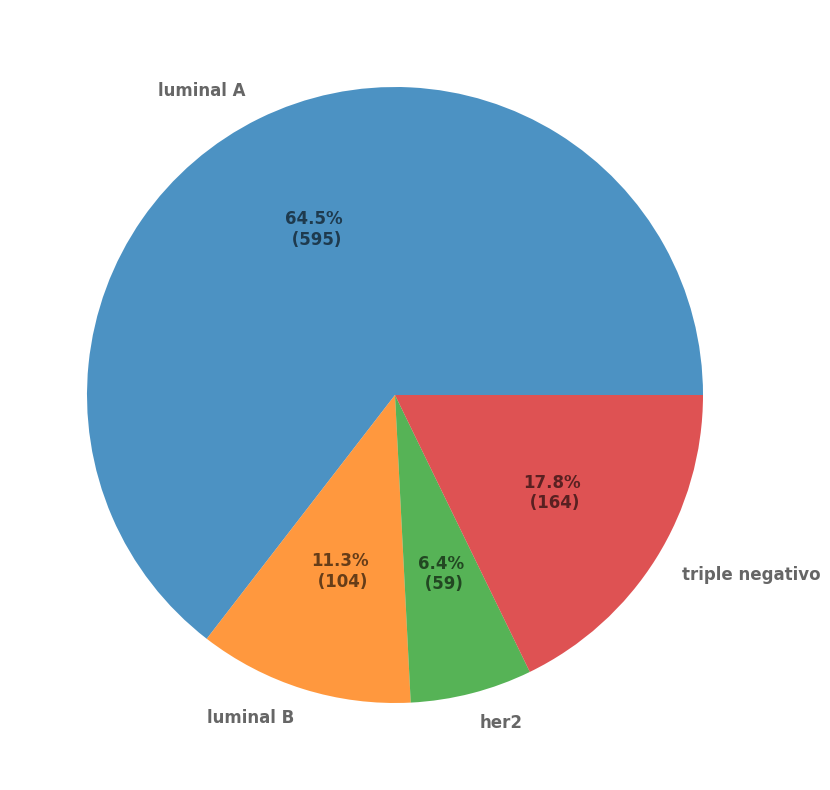

In [ ]:
grafico_tarta_subtipos(y)

##**Funcion uno contra otros**

In [ ]:
def creacion_de_un_problema_binario(y):
  problem = []
  chosen_problems = ["luminal_A","luminal_B","her2","triple_negativo"]
  for i in range(len(chosen_problems)):
      df = y.drop(["Patient ID","ER","PR","HER2"], axis=1) # del dataframe original, se eliminan las columnas indicadas, dejando la columna "Molecular Subtype" como el objetivo
      # Transforma los otros subtipos definidos como clase 1, donde la clase 0 corresponde al tipo seleccionado.
      if chosen_problems[i] =="luminal_A":
        df.loc[df['Mol Subtype'] == 2, 'Mol Subtype'] = 1
        df.loc[df['Mol Subtype'] == 3, 'Mol Subtype'] = 1
        problem.append(list(df['Mol Subtype']))

      elif chosen_problems[i] =="luminal_B":
        df.loc[df['Mol Subtype'] == 0, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 1, 'Mol Subtype'] = 0
        df.loc[df['Mol Subtype'] == 2, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 3, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 4, 'Mol Subtype'] = 1
        problem.append(list(df['Mol Subtype']))
      elif chosen_problems[i] =="her2":
        df.loc[df['Mol Subtype'] == 0, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 1, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 2, 'Mol Subtype'] = 0
        df.loc[df['Mol Subtype'] == 3, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 4, 'Mol Subtype'] = 1
        problem.append(list(df['Mol Subtype']))
      else:
        df.loc[df['Mol Subtype'] == 0, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 1, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 2, 'Mol Subtype'] = 4
        df.loc[df['Mol Subtype'] == 3, 'Mol Subtype'] = 0
        df.loc[df['Mol Subtype'] == 4, 'Mol Subtype'] = 1
        problem.append(list(df['Mol Subtype']))

  # Obtener las clases únicas y sus frecuencias
  class_mol, luminal_A = np.unique(problem[0], return_counts=True)
  class_er, luminal_B = np.unique(problem[1], return_counts=True)
  class_pr, her2 = np.unique(problem[2], return_counts=True)
  class_h2r, triple_negative = np.unique(problem[3], return_counts=True)

  class_A = ["luminal A","otros"]
  class_B = ["luminal B","otros"]
  class_H2 = ["her2","otros"]
  class_TN = ["triple negativo", "otros"]

  # Crear la figura y los subplots
  fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

  # Graficar los datos en cada subplot
  axs[0, 0].pie(luminal_A, labels=class_A)
  axs[0, 0].set_title('luminal A vs otros')
  axs[0, 1].pie(luminal_B, labels=class_B)
  axs[0, 1].set_title('luminal B vs otros')
  axs[1, 0].pie(her2, labels=class_H2)
  axs[1, 0].set_title('her2 vs otros')
  axs[1, 1].pie(triple_negative, labels=class_TN)
  axs[1, 1].set_title('triple negativo vs otros')

  # Ajustar los subplots
  plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
  plt.savefig("/content/drive/MyDrive/Radiomics_Oversampling/Exploration_of_the_date/anexo_2_distribucion_de_clase_one_vs_rest.png", dpi=300, bbox_inches='tight')    
  # Mostrar la figura
  plt.show()


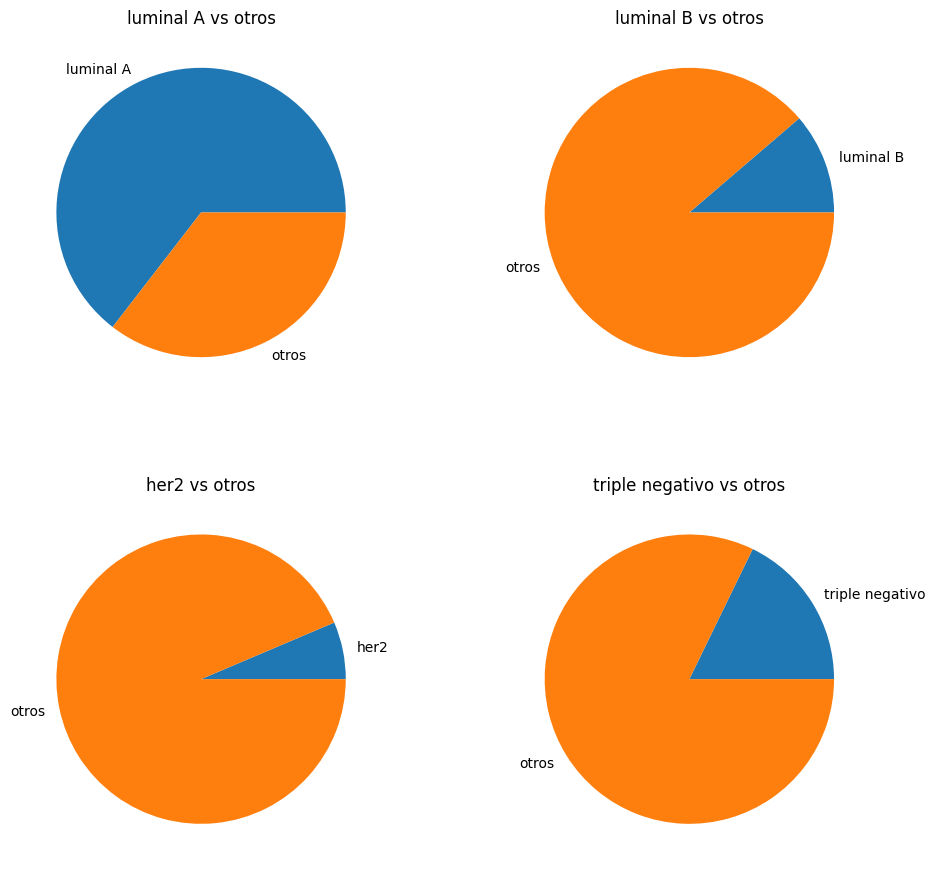

In [ ]:
creacion_de_un_problema_binario(y)

#**Exploracion de datos por grupo de caracteristicas**

###**1-Volumen de la mama y tejido fibroglandular.**

In [ ]:
#Filtro solo caracteristicas asociadas a volumen de la mama y tejido fibroglandular. Son solo 5 caracteristicas mas la etiqueta
Breast_and_FGT_Volume_Features = X[["BreastVol","tissueVol_T1","breastDensity_T1","tissueVol_PostCon","breastDensity_PostCon"]]
Breast_and_FGT_Volume_Features

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Breast_and_FGT_Volume_Features)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Breast_and_FGT_Volume_Features.html")

<Axes: >

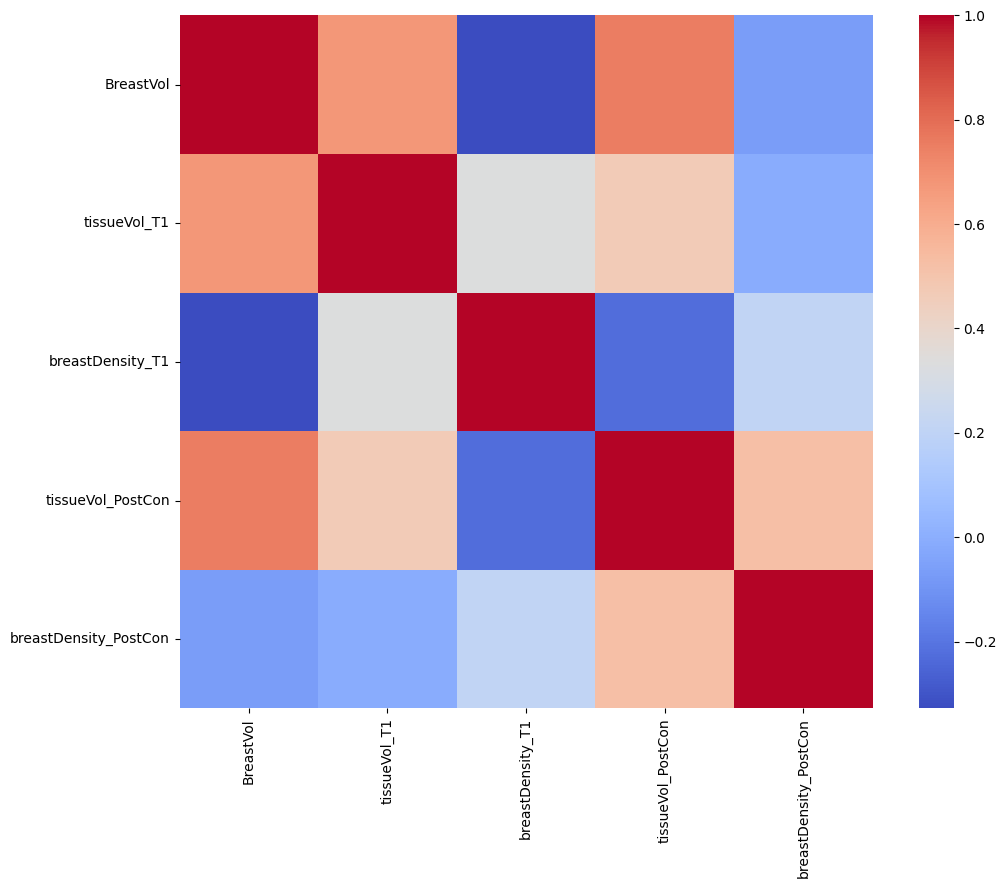

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Breast_and_FGT_Volume_Features= Breast_and_FGT_Volume_Features.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Breast_and_FGT_Volume_Features, vmax=1, square=True, cmap='coolwarm')

###**2- Tamaño y formologia del tumor.**

In [ ]:
#Filtro solo caracteristicas asociadas a tamaño y formologia del tumor. Son solo 10 caracteristicas mas la etiqueta
Tumor_Size_and_Morphology = X[["TumorMajorAxisLength_mm","Median_solidity_Tumor","Median_Elongation_Tumor","Median_Euler_No_Tumor", "BEVR_Tumor","BEDR1_Tumor","BEDR2_Tumor","MF_Tumor","ASD_Tumor","Volume_cu_mm_Tumor"]]
Tumor_Size_and_Morphology

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Tumor_Size_and_Morphology)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Tumor_Size_and_Morphology.html")

<Axes: >

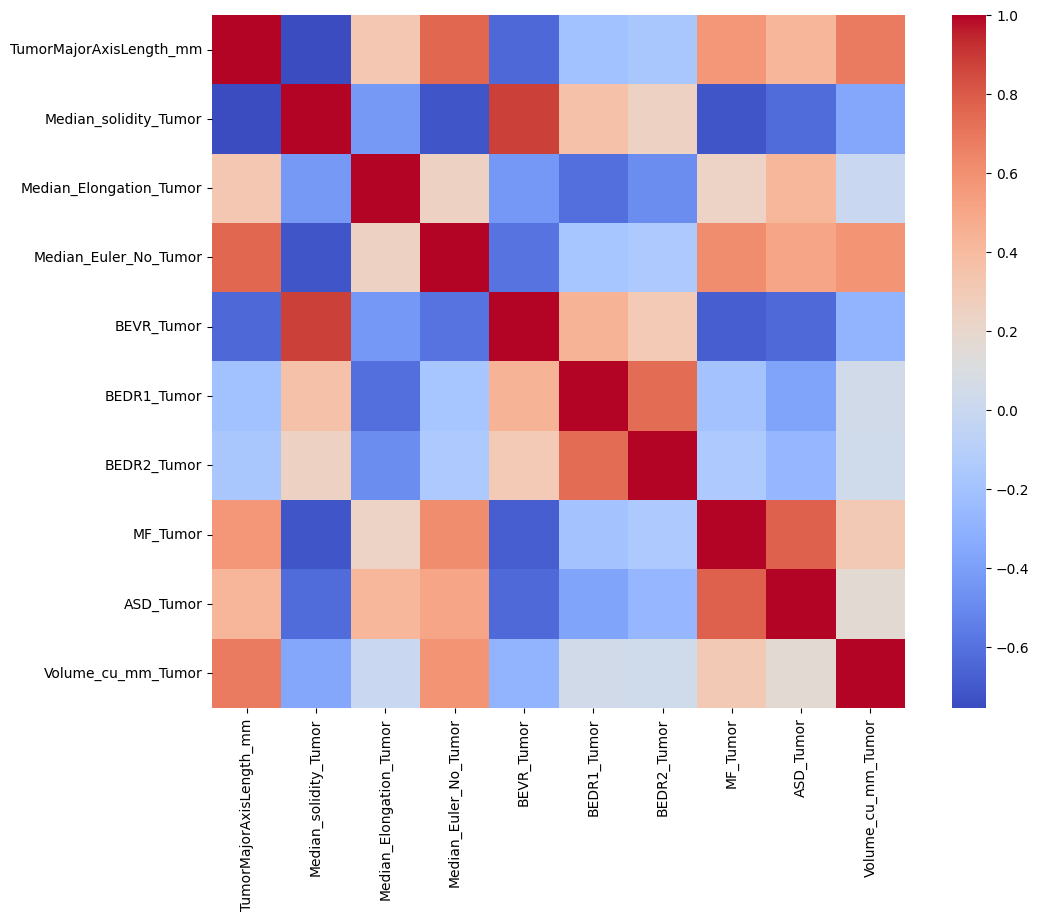

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Tumor_Size_and_Morphology = Tumor_Size_and_Morphology.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Tumor_Size_and_Morphology, vmax=1, square=True, cmap='coolwarm')

###**3-Realce del tejido fibroglandular.**

In [ ]:
#Filtro solo caracteristicas asociadas al relace del tejido fibroglandular. Son solo 82 caracteristicas mas la etiqueta
FGT_Enhancement = X[["Ratio_Tissue_vol_enhancing_more_than_0percent_from_T1_to_Breast_Vol", "Ratio_Tissue_vol_enhancing_more_than_10percent_from_T1_to_Breast_Vol", "Ratio_Tissue_vol_enhancing_more_than_20percent_from_T1_to_Breast_Vol", "Ratio_Tissue_vol_enhancing_more_than_30percent_from_T1_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_40percent_from_T1_to_Breast_Vol", "Ratio_Tissue_vol_enhancing_more_than_50percent_from_T1_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_60percent_from_T1_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_70percent_from_T1_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_80percent_from_T1_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_90percent_from_T1_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_100percent_from_T1_to_Breast_Vol", "Ratio_Tissue_vol_enhancing_more_than_0percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_10percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_20percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_30percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_40percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_50percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_60percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_70percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_80percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_90percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_100percent_from_T1_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_0percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_10percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_20percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_30percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_40percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_50percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_60percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_70percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_80percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_90percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_100percent_from_PostCon_to_Breast_Vol","Ratio_Tissue_vol_enhancing_more_than_0percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_10percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_20percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_30percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_40percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_50percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_60percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_70percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_80percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_90percent_from_PostCon_to_Tissue_Vol","Ratio_Tissue_vol_enhancing_more_than_100percent_from_PostCon_to_Tissue_Vol","Grouping_based_mean_of_peak_enhancement_slope_3D_tissue_T1_Group_1","Grouping_based_mean_of_peak_enhancement_slope_3D_tissue_T1_Group_2","Grouping_based_mean_of_peak_enhancement_slope_3D_tissue_T1_Group_3","Grouping_based_mean_of_washin_slope_3D_tissue_T1_Group_1","Grouping_based_mean_of_washin_slope_3D_tissue_T1_Group_2","Grouping_based_mean_of_washin_slope_3D_tissue_T1_Group_3","Grouping_based_mean_of_washout_slope_3D_tissue_T1_Group_1","Grouping_based_mean_of_washout_slope_3D_tissue_T1_Group_2","Grouping_based_proportion_of_3D_tissue_T1_Group_1","Grouping_based_proportion_of_3D_tissue_T1_Group_2","Grouping_based_proportion_of_3D_tissue_T1_Group_3","Grouping_based_mean_of_peak_enhancement_slope_3D_tissue_PostCon_Group_1","Grouping_based_mean_of_peak_enhancement_slope_3D_tissue_PostCon_Group_2","Grouping_based_mean_of_peak_enhancement_slope_3D_tissue_PostCon_Group_3","Grouping_based_mean_of_washin_slope_3D_tissue_PostCon_Group_1","Grouping_based_mean_of_washin_slope_3D_tissue_PostCon_Group_2","Grouping_based_mean_of_washin_slope_3D_tissue_PostCon_Group_3","Grouping_based_mean_of_washout_slope_3D_tissue_PostCon_Group_1","Grouping_based_mean_of_washout_slope_3D_tissue_PostCon_Group_2","Grouping_based_proportion_of_3D_tissue_PostCon_Group_3","SER_Total_tissue_vol_cu_mm_T1","SER_Partial_tissue_vol_cu_mm_T1","SER_Washout_tissue_vol_cu_mm_T1","Peak_SER_tissue_T1","Peak_PE_tissue_T1","SER_map_mean_tissue_T1","PE_map_mean_tissue_T1","WashinRate_map_mean_tissue_T1","SER_Total_tissue_vol_cu_mm_PostCon","SER_Partial_tissue_vol_cu_mm_PostCon","SER_Washout_tissue_vol_cu_mm_PostCon","Peak_SER_tissue_PostCon","Peak_PE_tissue_PostCon","SER_map_mean_tissue_PostCon","PE_map_mean_tissue_PostCon","WashinRate_map_mean_tissue_PostCon"]]
FGT_Enhancement

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(FGT_Enhancement)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/FGT_Enhancement.html")

<Axes: >

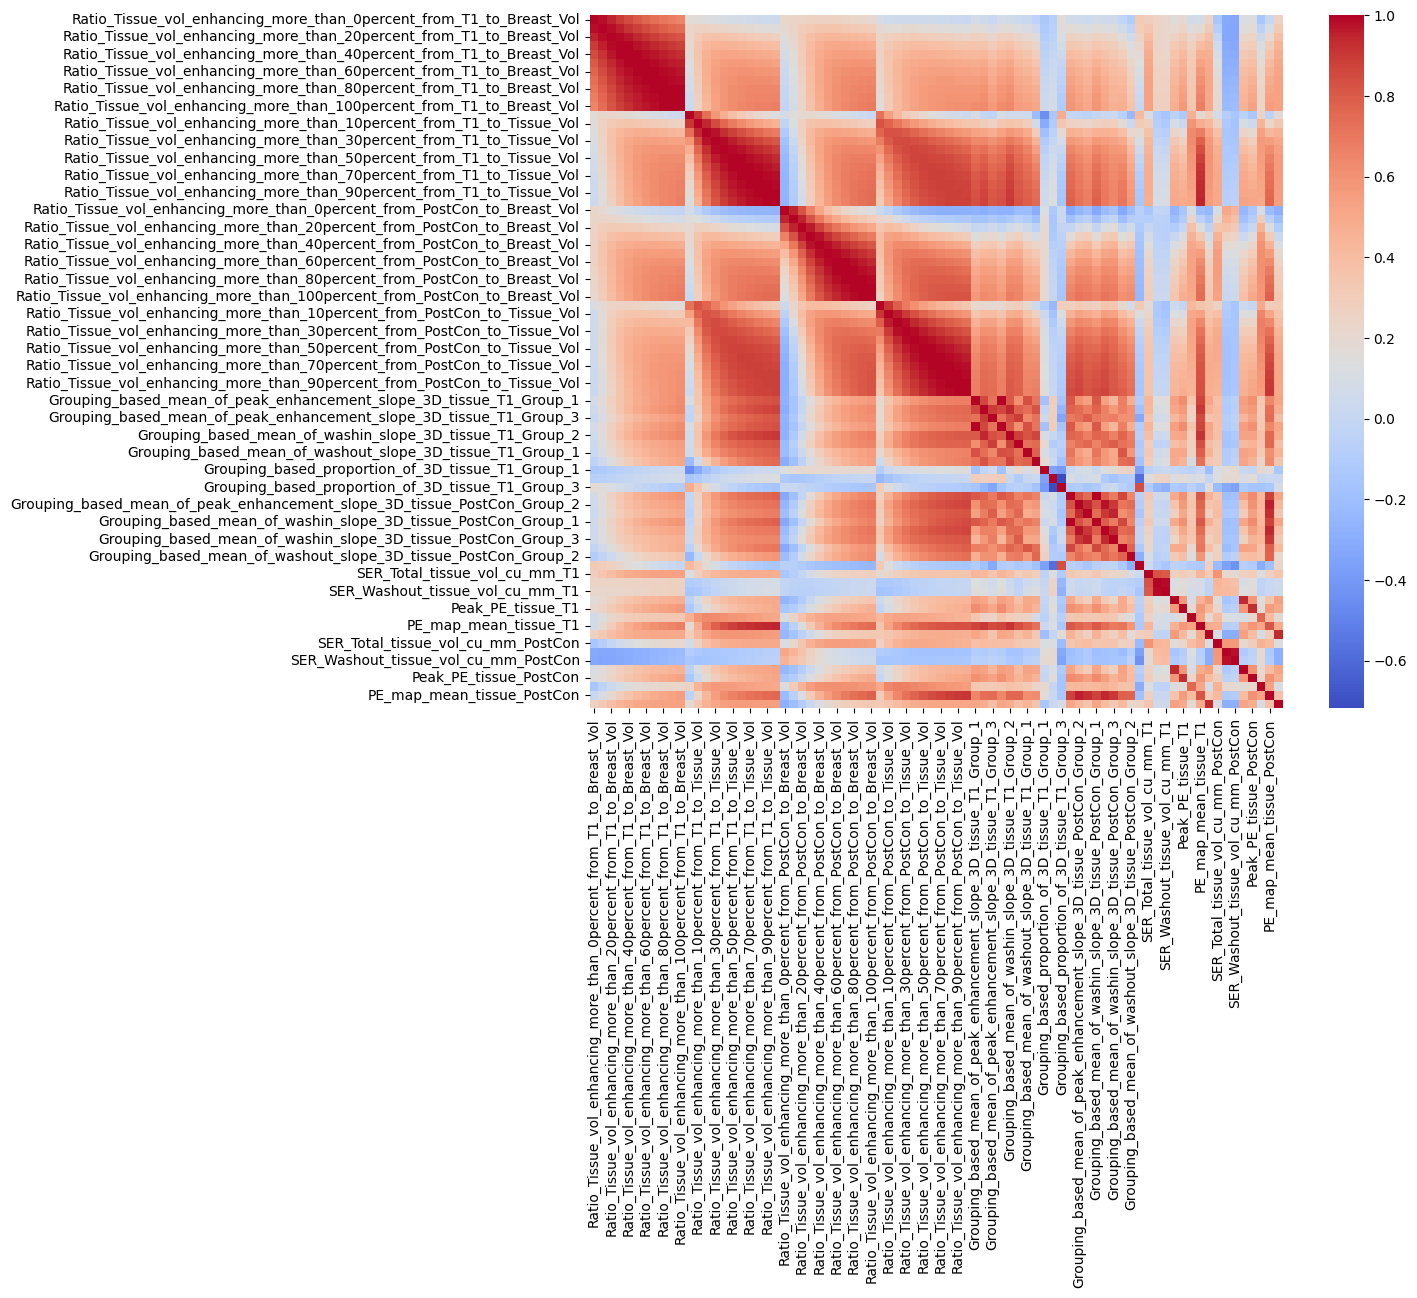

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_FGT_Enhancement = FGT_Enhancement .corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_FGT_Enhancement, vmax=1, square=True, cmap='coolwarm')

###**4- Realce del tumor.**

In [ ]:
#Filtro solo caracteristicas asociadas al relace del tumor. Son solo 30 caracteristicas mas la etiqueta
Tumor_Enhancement = X[["Grouping_based_mean_of_peak_enhancement_slope_3D_tumor_Group_1","Grouping_based_mean_of_peak_enhancement_slope_3D_tumor_Group_2","Grouping_based_mean_of_peak_enhancement_slope_3D_tumor_Group_3","Grouping_based_mean_of_washin_slope_3D_tumor_Group_1","Grouping_based_mean_of_washin_slope_3D_tumor_Group_2","Grouping_based_mean_of_washin_slope_3D_tumor_Group_3","Grouping_based_mean_of_washout_slope_3D_tumor_Group_1","Grouping_based_mean_of_washout_slope_3D_tumor_Group_2","Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_1","Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_2","Grouping_based_proportion_of_tumor_voxels_3D_tumor_Group_3","Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_1","Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_2","Grouping_based_mean_of_peak_enhancement_slope_2D_tumorSlice_Group_3","Grouping_based_mean_of_washin_slope_2D_tumorSlice_Group_1","Grouping_based_mean_of_washin_slope_2D_tumorSlice_Group_2","Grouping_based_mean_of_washin_slope_2D_tumorSlice_Group_3","Grouping_based_mean_of_washout_slope_2D_tumorSlice_Group_1","Grouping_based_mean_of_washout_slope_2D_tumorSlice_Group_2","Grouping_based_proportion_of_tumor_voxels_2D_tumorSlice_Group_1","Grouping_based_proportion_of_tumor_voxels_2D_tumorSlice_Group_2","Grouping_based_proportion_of_tumor_voxels_2D_tumorSlice_Group_3","SER_Total_tumor_vol_cu_mm","SER_Partial_tumor_vol_cu_mm","SER_Washout_tumor_vol_cu_mm","Peak_SER_tumor","Peak_PE_tumor","SER_map_mean_tumor","PE_map_mean_tumor","WashinRate_map_mean_tumor"]]


In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Tumor_Enhancement)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Tumor_Enhancement.html")

<Axes: >

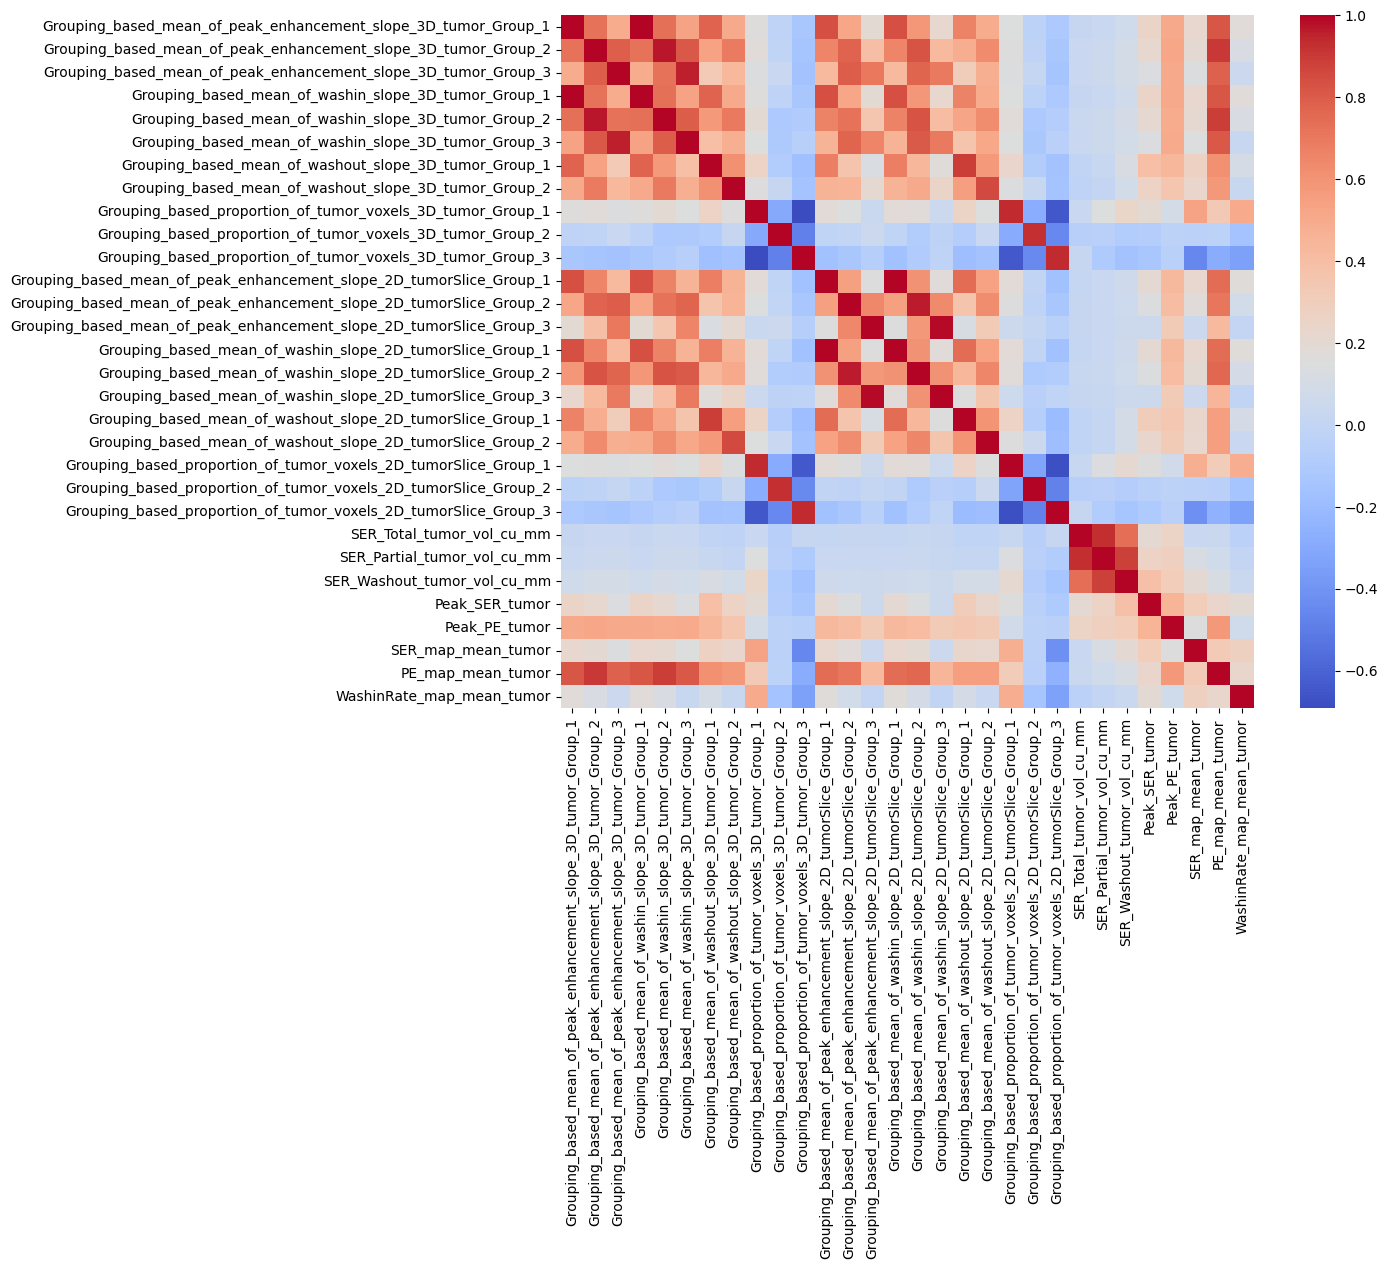

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Tumor_Enhancement = Tumor_Enhancement.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Tumor_Enhancement, vmax=1, square=True, cmap='coolwarm')

###**5-Combinacion realce del tumor y tejido fibroglandular .**

In [ ]:
#Filtro solo caracteristicas asociadas al relace del tumor y tejido fibroglandular. Son solo 18 caracteristicas mas la etiqueta
Combining_Tumor_and_FGT_Enhancement = X[['F1_DT_T1NFS (T11=0.05,T12=0.5)',"F1_DT_T1NFS(T11=0.05,T12=0.1)","F1_DT_T1NFS (T11=0.02,T12=0.5)","F1_DT_T1NFS (T11=0.02,T12=0.8)","F1_DT_T1NFS (T11=0.05,T12=0.8)","F1_DT_T1NFS (T11=0.1,T12=0.5)","F1_DT_T1NFS (T11=0.1,T12=0.8)","F1_DT_T1NFS (T11=0.2,T12=0.5)","F1_DT_T1NFS (T11=0.2,T12=0.8)","F1_DT_POSTCON (T11=0.05,T12=0.5)","F1_DT_POSTCON (T11=0.05,T12=0.1)","F1_DT_POSTCON (T11=0.02,T12=0.5)","F1_DT_POSTCON (T11=0.02,T12=0.8)","F1_DT_POSTCON (T11=0.05,T12=0.8)","F1_DT_POSTCON (T11=0.1,T12=0.5)","F1_DT_POSTCON (T11=0.1,T12=0.8)","F1_DT_POSTCON (T11=0.2,T12=0.5)","F1_DT_POSTCON (T11=0.2,T12=0.8)"]]

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Combining_Tumor_and_FGT_Enhancement)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Combining_Tumor_and_FGT_Enhancement.html")

<Axes: >

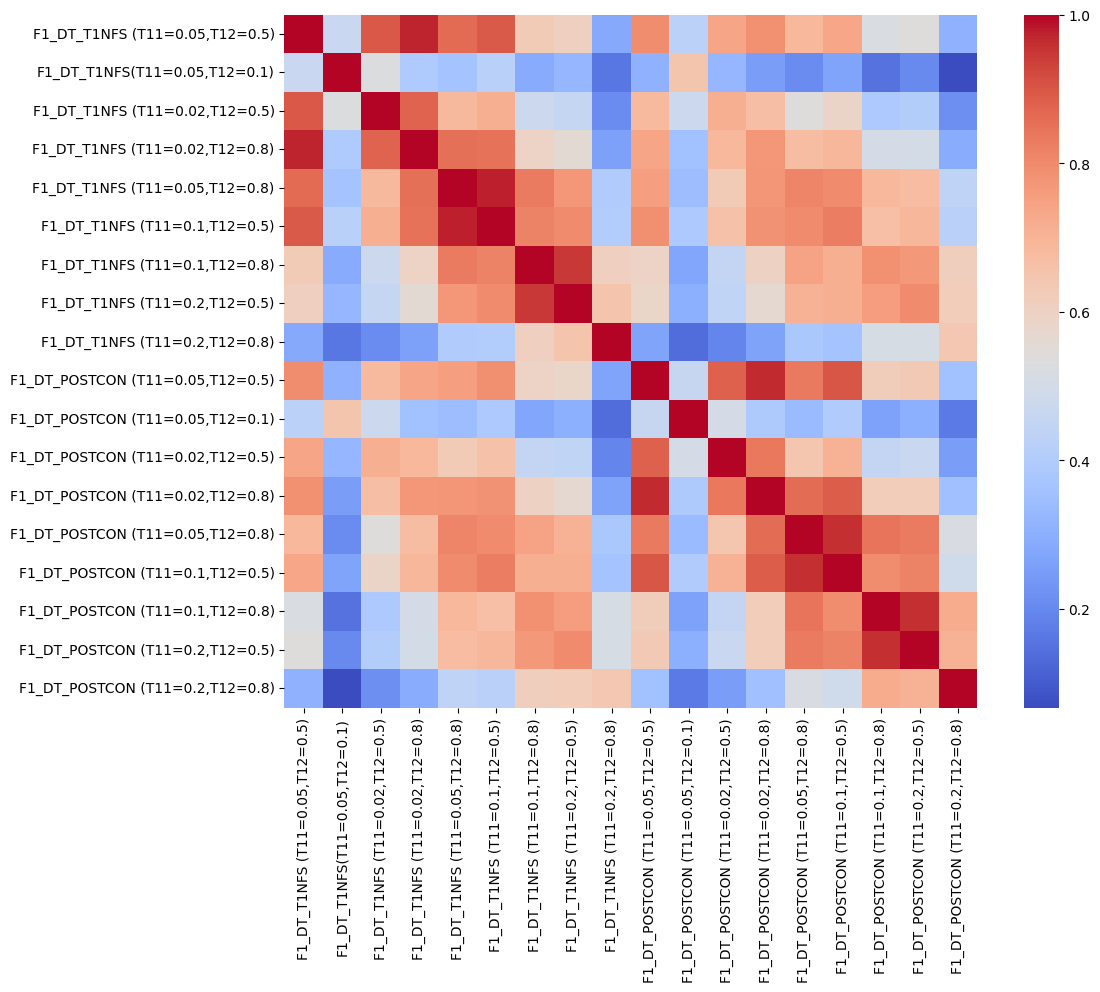

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Combining_Tumor_and_FGT_Enhancement = Combining_Tumor_and_FGT_Enhancement.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Combining_Tumor_and_FGT_Enhancement, vmax=1, square=True,cmap='coolwarm')

###**6-Textura del realce del tejido fibroglandular .**



In [ ]:
#Filtro solo caracteristicas asociadas a la textura del relace tejido fibroglandular. Son solo 176 caracteristicas mas la etiqueta
FGT_Enhancement_Texture = X[["Autocorrelation_tissue_T1","Contrast_tissue_T1","Correlation1_tissue_T1","Correlation2_tissue_T1","Cluster_Prominence_tissue_T1","Cluster_Shade_tissue_T1","Dissimilarity_tissue_T1","Energy_tissue_T1","Entropy_tissue_T1","Homogeneity1_tissue_T1","Homogeneity2_tissue_T1","Max_Probability_tissue_T1","Sum_of_Squares_variance_tissue_T1","sum_average_tissue_T1","sum_variance__tissue_T1","sum_entropy_tissue_T1","difference_entropy_tissue_T1","information_measure_correlation1_tissue_T1","information_measure_correlation2_tissue_T1","inverse_difference_is_homom_tissue_T1","inverse_difference_normalized_tissue_T1","inverse_difference_moment_normalized_tissue_T1","Autocorrelation_tissue_PostCon","Contrast_tissue_PostCon","Correlation1_tissue_PostCon","Correlation2_tissue_PostCon","Cluster_Prominence_tissue_PostCon","Cluster_Shade_tissue_PostCon","Dissimilarity_tissue_PostCon","Energy_tissue_PostCon","Entropy_tissue_PostCon","Homogeneity1_tissue_PostCon","Homogeneity2_tissue_PostCon","Max_Probability_tissue_PostCon","Sum_of_Squares_variance_tissue_PostCon","sum_average_tissue_PostCon","sum_variance__tissue_PostCon","sum_entropy_tissue_PostCon","difference_entropy_tissue_PostCon","information_measure_correlation1_tissue_PostCon","information_measure_correlation2_tissue_PostCon","inverse_difference_is_homom_tissue_PostCon","inverse_difference_normalized_tissue_PostCon","inverse_difference_moment_normalized_tissue_PostCon","SER_map_Autocorrelation_tissue_T1","SER_map_Contrast_tissue_T1","SER_map_Correlation1_tissue_T1","SER_map_Correlation2_tissue_T1","SER_map_Cluster_Prominence_tissue_T1","SER_map_Cluster_Shade_tissue_T1","SER_map_Dissimilarity_tissue_T1","SER_map_Energy_tissue_T1","SER_map_Entropy_tissue_T1","SER_map_Homogeneity1_tissue_T1","SER_map_Homogeneity2_tissue_T1","SER_map_Max_Probability_tissue_T1","SER_map_Sum_of_Squares_variance_tissue_T1","SER_map_sum_average_tissue_T1","SER_map_sum_variance__tissue_T1","SER_map_sum_entropy_tissue_T1","SER_map_difference_entropy_tissue_T1","SER_map_information_measure_correlation1_tissue_T1","SER_map_information_measure_correlation2_tissue_T1","SER_map_inverse_difference_is_homom_tissue_T1","SER_map_inverse_difference_normalized_tissue_T1","SER_map_inverse_difference_moment_normalized_tissue_T1","PE_map_Autocorrelation_tissue_T1","PE_map_Contrast_tissue_T1","PE_map_Correlation1_tissue_T1","PE_map_Correlation2_tissue_T1","PE_map_Cluster_Shade_tissue_T1","PE_map_Dissimilarity_tissue_T1","PE_map_Energy_tissue_T1","PE_map_Entropy_tissue_T1","PE_map_Homogeneity1_tissue_T1","PE_map_Homogeneity2_tissue_T1","PE_map_Max_Probability_tissue_T1","PE_map_Sum_of_Squares_variance_tissue_T1","PE_map_sum_average_tissue_T1","PE_map_sum_variance__tissue_T1","PE_map_sum_entropy_tissue_T1","PE_map_difference_entropy_tissue_T1","PE_map_information_measure_correlation1_tissue_T1","PE_map_information_measure_correlation2_tissue_T1","PE_map_inverse_difference_is_homom_tissue_T1","PE_map_inverse_difference_normalized_tissue_T1","PE_map_inverse_difference_moment_normalized_tissue_T1","WashinRate_map_Autocorrelation_tissue_T1","WashinRate_map_Contrast_tissue_T1","WashinRate_map_Correlation1_tissue_T1","WashinRate_map_Correlation2_tissue_T1","WashinRate_map_Cluster_Prominence_tissue_T1","WashinRate_map_Cluster_Shade_tissue_T1","WashinRate_map_Dissimilarity_tissue_T1","WashinRate_map_Energy_tissue_T1","WashinRate_map_Entropy_tissue_T1","WashinRate_map_Homogeneity1_tissue_T1","WashinRate_map_Homogeneity2_tissue_T1","WashinRate_map_Max_Probability_tissue_T1","WashinRate_map_Sum_of_Squares_variance_tissue_T1","WashinRate_map_sum_average_tissue_T1","WashinRate_map_sum_variance__tissue_T1","WashinRate_map_sum_entropy_tissue_T1","WashinRate_map_difference_entropy_tissue_T1","WashinRate_map_information_measure_correlation1_tissue_T1","WashinRate_map_information_measure_correlation2_tissue_T1","WashinRate_map_inverse_difference_is_homom_tissue_T1","WashinRate_map_inverse_difference_normalized_tissue_T1","WashinRate_map_inverse_difference_moment_normalized_tissue_T1","SER_map_Autocorrelation_tissue_PostCon","SER_map_Contrast_tissue_PostCon","SER_map_Correlation1_tissue_PostCon","SER_map_Correlation2_tissue_PostCon","SER_map_Cluster_Prominence_tissue_PostCon","SER_map_Cluster_Shade_tissue_PostCon","SER_map_Dissimilarity_tissue_PostCon","SER_map_Energy_tissue_PostCon","SER_map_Entropy_tissue_PostCon","SER_map_Homogeneity1_tissue_PostCon","SER_map_Homogeneity2_tissue_PostCon","SER_map_Max_Probability_tissue_PostCon","SER_map_Sum_of_Squares_variance_tissue_PostCon","SER_map_sum_average_tissue_PostCon","SER_map_sum_variance__tissue_PostCon","SER_map_sum_entropy_tissue_PostCon","SER_map_difference_entropy_tissue_PostCon","SER_map_information_measure_correlation1_tissue_PostCon","SER_map_information_measure_correlation2_tissue_PostCon","SER_map_inverse_difference_is_homom_tissue_PostCon","SER_map_inverse_difference_normalized_tissue_PostCon","SER_map_inverse_difference_moment_normalized_tissue_PostCon","PE_map_Autocorrelation_tissue_PostCon","PE_map_Contrast_tissue_PostCon","PE_map_Correlation1_tissue_PostCon","PE_map_Correlation2_tissue_PostCon","PE_map_Cluster_Prominence_tissue_PostCon","PE_map_Cluster_Shade_tissue_PostCon","PE_map_Dissimilarity_tissue_PostCon","PE_map_Energy_tissue_PostCon","PE_map_Entropy_tissue_PostCon","PE_map_Homogeneity1_tissue_PostCon","PE_map_Homogeneity2_tissue_PostCon","PE_map_Max_Probability_tissue_PostCon","PE_map_Sum_of_Squares_variance_tissue_PostCon","PE_map_sum_average_tissue_PostCon","PE_map_sum_variance__tissue_PostCon","PE_map_sum_entropy_tissue_PostCon","PE_map_difference_entropy_tissue_PostCon","PE_map_information_measure_correlation1_tissue_PostCon","PE_map_information_measure_correlation2_tissue_PostCon","PE_map_inverse_difference_is_homom_tissue_PostCon","PE_map_inverse_difference_normalized_tissue_PostCon","PE_map_inverse_difference_moment_normalized_tissue_PostCon","WashinRate_map_Autocorrelation_tissue_PostCon","WashinRate_map_Contrast_tissue_PostCon","WashinRate_map_Correlation1_tissue_PostCon","WashinRate_map_Correlation2_tissue_PostCon","WashinRate_map_Cluster_Prominence_tissue_PostCon","WashinRate_map_Cluster_Shade_tissue_PostCon","WashinRate_map_Dissimilarity_tissue_PostCon","WashinRate_map_Energy_tissue_PostCon","WashinRate_map_Entropy_tissue_PostCon","WashinRate_map_Homogeneity1_tissue_PostCon","WashinRate_map_Homogeneity2_tissue_PostCon","WashinRate_map_Max_Probability_tissue_PostCon","WashinRate_map_Sum_of_Squares_variance_tissue_PostCon","WashinRate_map_sum_average_tissue_PostCon","WashinRate_map_sum_variance__tissue_PostCon","WashinRate_map_difference_entropy_tissue_PostCon","WashinRate_map_information_measure_correlation1_tissue_PostCon","WashinRate_map_information_measure_correlation2_tissue_PostCon","WashinRate_map_inverse_difference_is_homom_tissue_PostCon","WashinRate_map_inverse_difference_normalized_tissue_PostCon","WashinRate_map_inverse_difference_moment_normalized_tissue_PostCon"]]

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(FGT_Enhancement_Texture)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/FGT_Enhancement_Texture.html")

<Axes: >

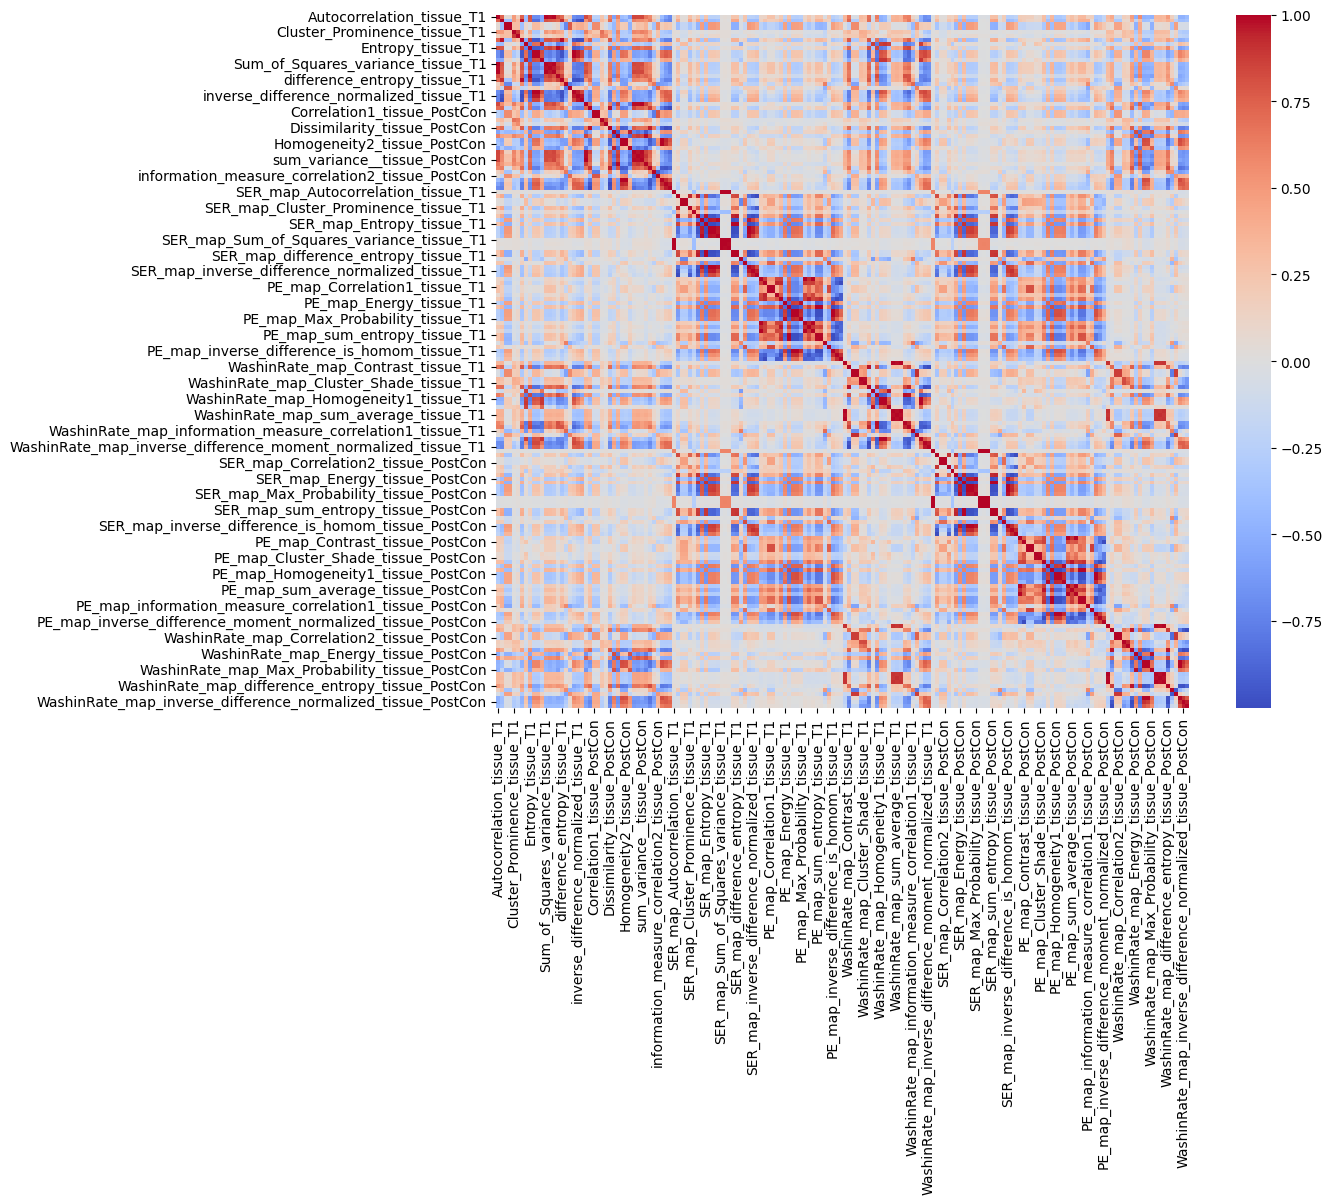

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_FGT_Enhancement_Texture = FGT_Enhancement_Texture.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_FGT_Enhancement_Texture, vmax=1, square=True,cmap='coolwarm')

###**7-Textura del realce del tumor .**

In [ ]:
#Filtro solo caracteristicas asociadas a la textura del relace tejido fibroglandular. Son solo 176 caracteristicas mas la etiqueta
Tumor_Enhancement_Texture = X[["1st_DFT_CoeffMap_Momment_Invariant_1_3D_tumor", "1st_DFT_CoeffMap_Momment_Invariant_2_3D_tumor","1st_DFT_CoeffMap_Momment_Invariant_3_3D_tumor", "1st_DFT_CoeffMap_Momment_Invariant_4_3D_tumor","1st_DFT_CoeffMap_Momment_Invariant_5_3D_tumor","1st_DFT_CoeffMap_Momment_Invariant_6_3D_tumor","1st_DFT_CoeffMap_Momment_Invariant_7_3D_tumor","2nd_DFT_CoeffMap_Momment_Invariant_1_3D_tumor","2nd_DFT_CoeffMap_Momment_Invariant_2_3D_tumor","2nd_DFT_CoeffMap_Momment_Invariant_3_3D_tumor","2nd_DFT_CoeffMap_Momment_Invariant_4_3D_tumor","1st_DFT_CoeffMap_Momment_Invariant_1_2D_tumorSlice","1st_DFT_CoeffMap_Momment_Invariant_2_2D_tumorSlice","1st_DFT_CoeffMap_Momment_Invariant_3_2D_tumorSlice","1st_DFT_CoeffMap_Momment_Invariant_4_2D_tumorSlice","1st_DFT_CoeffMap_Momment_Invariant_5_2D_tumorSlice","1st_DFT_CoeffMap_Momment_Invariant_6_2D_tumorSlice","1st_DFT_CoeffMap_Momment_Invariant_7_2D_tumorSlice","2nd_DFT_CoeffMap_Momment_Invariant_1_2D_tumorSlice","2nd_DFT_CoeffMap_Momment_Invariant_2_2D_tumorSlice","2nd_DFT_CoeffMap_Momment_Invariant_3_2D_tumorSlice","2nd_DFT_CoeffMap_Momment_Invariant_4_2D_tumorSlice","Mean_norm_DHOG_max_timepoint_binsize_2_without_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_4_without_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_6_without_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_8_without_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_10_without_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_8_without_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_16_without_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_33_without_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_64_without_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_128_without_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_256_without_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_2_with_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_4_with_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_6_with_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_8_with_filling_Tumor","Mean_norm_DHOG_max_timepoint_binsize_10_with_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_8_with_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_16_with_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_33_with_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_64_with_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_128_with_filling_Tumor","Mean_norm_DLBP_max_timepoint_binsize_256_with_filling_Tumor","Margin_Gradient_Tumor","Variance_of_Margin_Gradient_Tumor","Variance_of_RGH_values_Tumor","SER_map_Autocorrelation_tumor","SER_map_Contrast_tumor","SER_map_Correlation1_tumor","SER_map_Correlation2_tumor","SER_map_Cluster_Prominence_tumor","SER_map_Cluster_Shade_tumor","SER_map_Dissimilarity_tumor","SER_map_Energy_tumor","SER_map_Entropy_tumor","SER_map_Homogeneity1_tumor","SER_map_Homogeneity2_tumor","SER_map_Max_Probability_tumor","SER_map_Sum_of_Squares_variance_tumor","SER_map_sum_average_tumor","SER_map_sum_variance__tumor","SER_map_sum_entropy_tumor","SER_map_difference_entropy_tumor","SER_map_information_measure_correlation1_tumor","SER_map_information_measure_correlation2_tumor","SER_map_inverse_difference_is_homom_tumor","SER_map_inverse_difference_normalized_tumor","SER_map_inverse_difference_moment_normalized_tumor","PE_map_Autocorrelation_tumor","PE_map_Contrast_tumor","PE_map_Correlation1_tumor","PE_map_Correlation2_tumor","PE_map_Cluster_Prominence_tumor","PE_map_Cluster_Shade_tumor","PE_map_Dissimilarity_tumor","PE_map_Energy_tumor","PE_map_Entropy_tumor","PE_map_Homogeneity1_tumor","PE_map_Homogeneity2_tumor","PE_map_Max_Probability_tumor","PE_map_Sum_of_Squares_variance_tumor","PE_map_sum_average_tumor","PE_map_sum_variance__tumor","PE_map_sum_entropy_tumor","PE_map_difference_entropy_tumor","PE_map_information_measure_correlation1_tumor","PE_map_information_measure_correlation2_tumor","PE_map_inverse_difference_is_homom_tumor","PE_map_inverse_difference_normalized_tumor","PE_map_inverse_difference_moment_normalized_tumor","WashinRate_map_Autocorrelation_tumor","WashinRate_map_Contrast_tumor","WashinRate_map_Correlation1_tumor","WashinRate_map_Correlation2_tumor","WashinRate_map_Cluster_Prominence_tumor","WashinRate_map_Dissimilarity_tumor","WashinRate_map_Energy_tumor","WashinRate_map_Entropy_tumor","WashinRate_map_Homogeneity1_tumor","WashinRate_map_Homogeneity2_tumor","WashinRate_map_Max_Probability_tumor","WashinRate_map_Sum_of_Squares_variance_tumor","WashinRate_map_sum_average_tumor","WashinRate_map_sum_variance__tumor","WashinRate_map_sum_entropy_tumor","WashinRate_map_difference_entropy_tumor","WashinRate_map_information_measure_correlation1_tumor","WashinRate_map_information_measure_correlation2_tumor","WashinRate_map_inverse_difference_is_homom_tumor","WashinRate_map_inverse_difference_normalized_tumor","WashinRate_map_inverse_difference_moment_normalized_tumor","Autocorrelation_Tumor","Contrast_Tumor","Correlation1_Tumor","Correlation2_Tumor","Cluster_Prominence_Tumor","Cluster_Shade_Tumor","Dissimilarity_Tumor","Energy_Tumor","Entropy_Tumor","Homogeneity1_Tumor","Homogeneity2_Tumor","Max_probability_Tumor","Sum_of_squares_variance_Tumor","Sum_avg_Tumor","Sum_variance_Tumor","Sum_entropy_Tumor","Diff_entropy_Tumor","Inf_mea_of_corr1_Tumor","Inf_mea_of_corr2_Tumor","Inv_Diff_homo_Tumor","Inv_Diff_normalized_Tumor","Inv_diff_moment_normalized_Tumor"]]

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Tumor_Enhancement_Texture)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Tumor_Enhancement_Texture.html")

<Axes: >

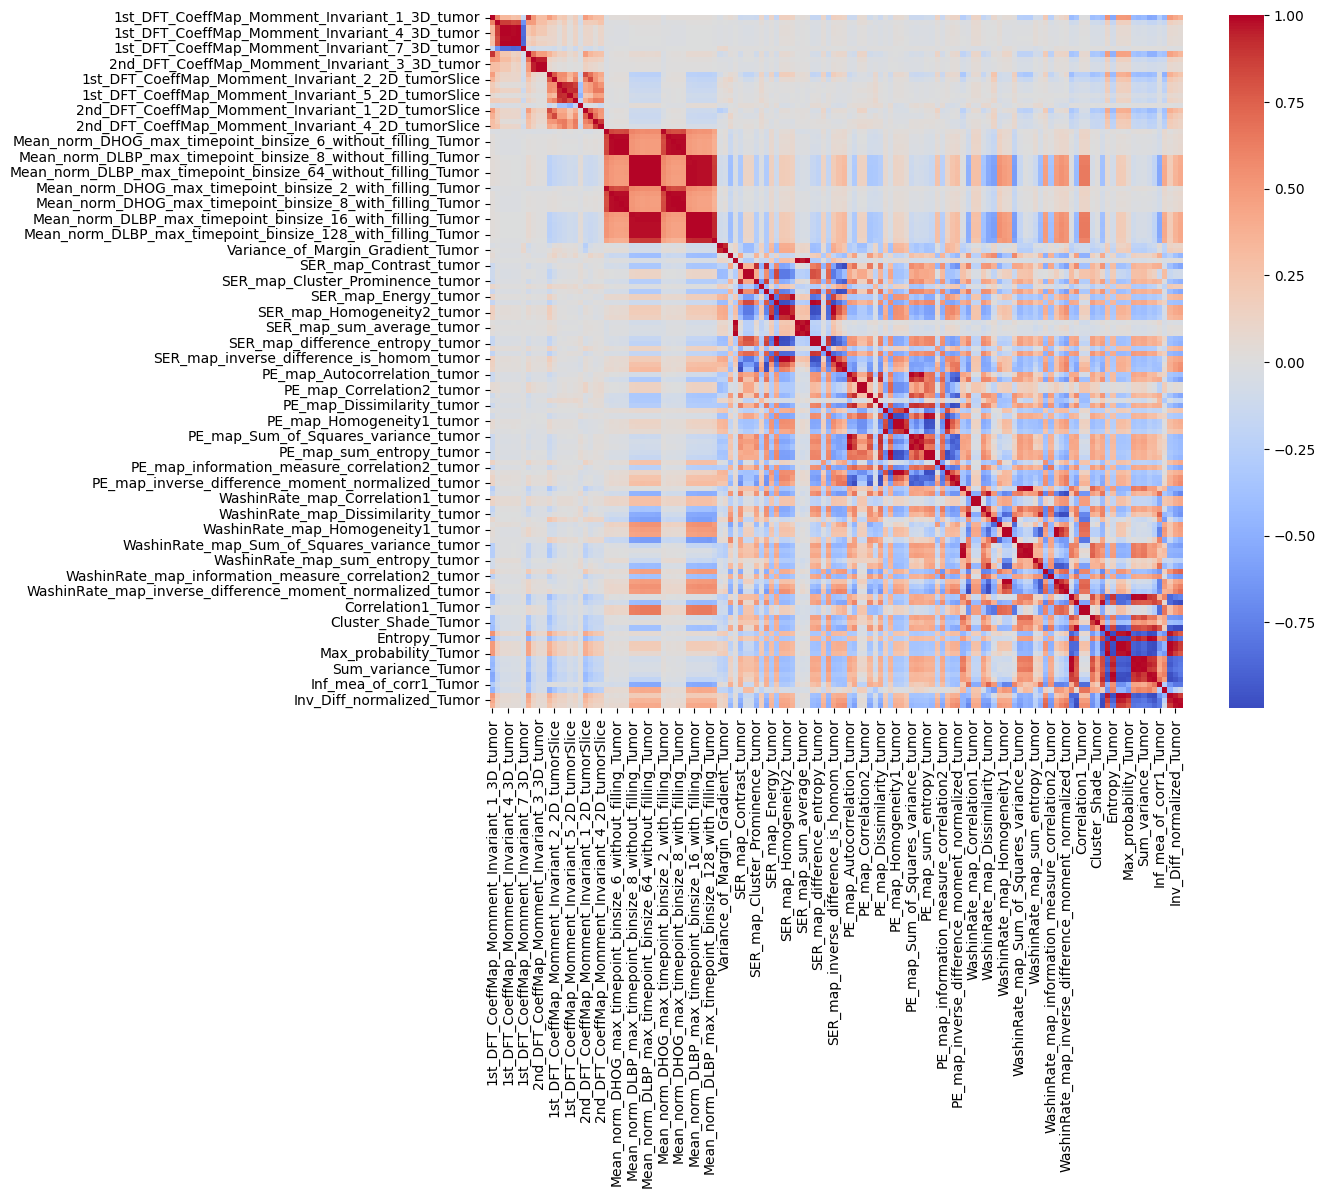

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Tumor_Enhancement_Texture = Tumor_Enhancement_Texture.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Tumor_Enhancement_Texture, vmax=1, square=True,cmap='coolwarm')

###**8-Heterogeneidad espacial del realce del tumor .**


In [ ]:
#Filtro solo caracteristicas asociadas a la textura del relace tejido fibroglandular. Son solo 4 caracteristicas mas la etiqueta
Tumor_Enhancement_Spatial_Heterogeneity = X[["globalMoransIEnhancementVarianceMap_Tumor","globalMoransISERMap_Tumor","EnhancementClusterNeighborhoodSimilarity_Tumor","EnhancementClusterDiscontinuity_Tumor"]]
#sweets = list(Tumor_Enhancement_Spatial_Heterogeneity.columns)

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Tumor_Enhancement_Spatial_Heterogeneity)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Tumor_Enhancement_Spatial_Heterogeneity.html")

<Axes: >

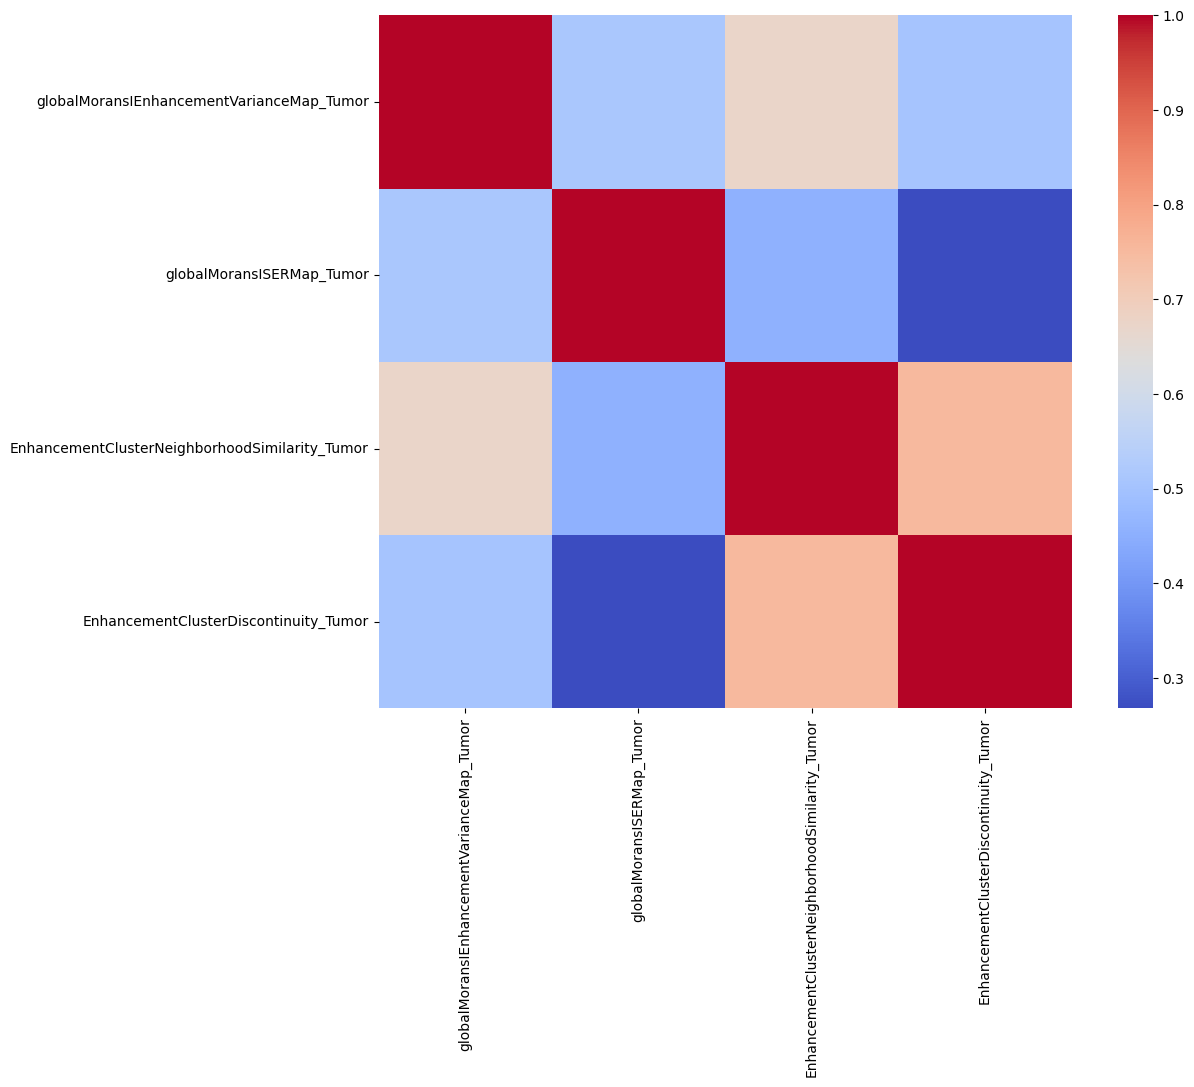

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Tumor_Enhancement_Spatial_Heterogeneity = Tumor_Enhancement_Spatial_Heterogeneity.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Tumor_Enhancement_Spatial_Heterogeneity, vmax=1, square=True,cmap='coolwarm')

###**9-Variacion del realce del tejido fibroglandular .**



In [ ]:
#Filtro solo caracteristicas asociadas a la textura del relace tejido fibroglandular. Son solo 34 caracteristicas mas la etiqueta
FGT_Enhancement_Variation = X[["Grouping_based_variance_of_peak_enhancement_slope_3D_tissue_T1_Group_1","Grouping_based_variance_of_peak_enhancement_slope_3D_tissue_T1_Group_2","Grouping_based_variance_of_peak_enhancement_slope_3D_tissue_T1_Group_3","Grouping_based_variance_of_washin_slope_3D_tissue_T1_Group_1","Grouping_based_variance_of_washin_slope_3D_tissue_T1_Group_2","Grouping_based_variance_of_washin_slope_3D_tissue_T1_Group_3","Grouping_based_variance_of_washout_slope_3D_tissue_T1_Group_1","Grouping_based_variance_of_washout_slope_3D_tissue_T1_Group_2","Grouping_based_variance_of_peak_enhancement_slope_3D_tissue_PostCon_Group_1","Grouping_based_variance_of_peak_enhancement_slope_3D_tissue_PostCon_Group_2","Grouping_based_variance_of_peak_enhancement_slope_3D_tissue_PostCon_Group_3","Grouping_based_variance_of_washin_slope_3D_tissue_PostCon_Group_1","Grouping_based_variance_of_washin_slope_3D_tissue_PostCon_Group_2","Grouping_based_variance_of_washin_slope_3D_tissue_PostCon_Group_3","Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_1","Grouping_based_variance_of_washout_slope_3D_tissue_PostCon_Group_2","SER_map_std_dev_tissue_T1","SER_map_skewness_tissue_T1","SER_map_kurtosis_tissue_T1","PE_map_std_dev_tissue_T1","PE_map_skewness_tissue_T1","PE_map_kurtosis_tissue_T1","WashinRate_map_std_dev_tissue_T1","WashinRate_map_skewness_tissue_T1","WashinRate_map_kurtosis_tissue_T1","SER_map_std_dev_tissue_PostCon","SER_map_skewness_tissue_PostCon","SER_map_kurtosis_tissue_PostCon","PE_map_std_dev_tissue_PostCon","PE_map_skewness_tissue_PostCon","PE_map_kurtosis_tissue_PostCon","WashinRate_map_std_dev_tissue_PostCon","WashinRate_map_skewness_tissue_PostCon","WashinRate_map_kurtosis_tissue_PostCon"]]

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(FGT_Enhancement_Variation)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/FGT_Enhancement_Variation.html")

<Axes: >

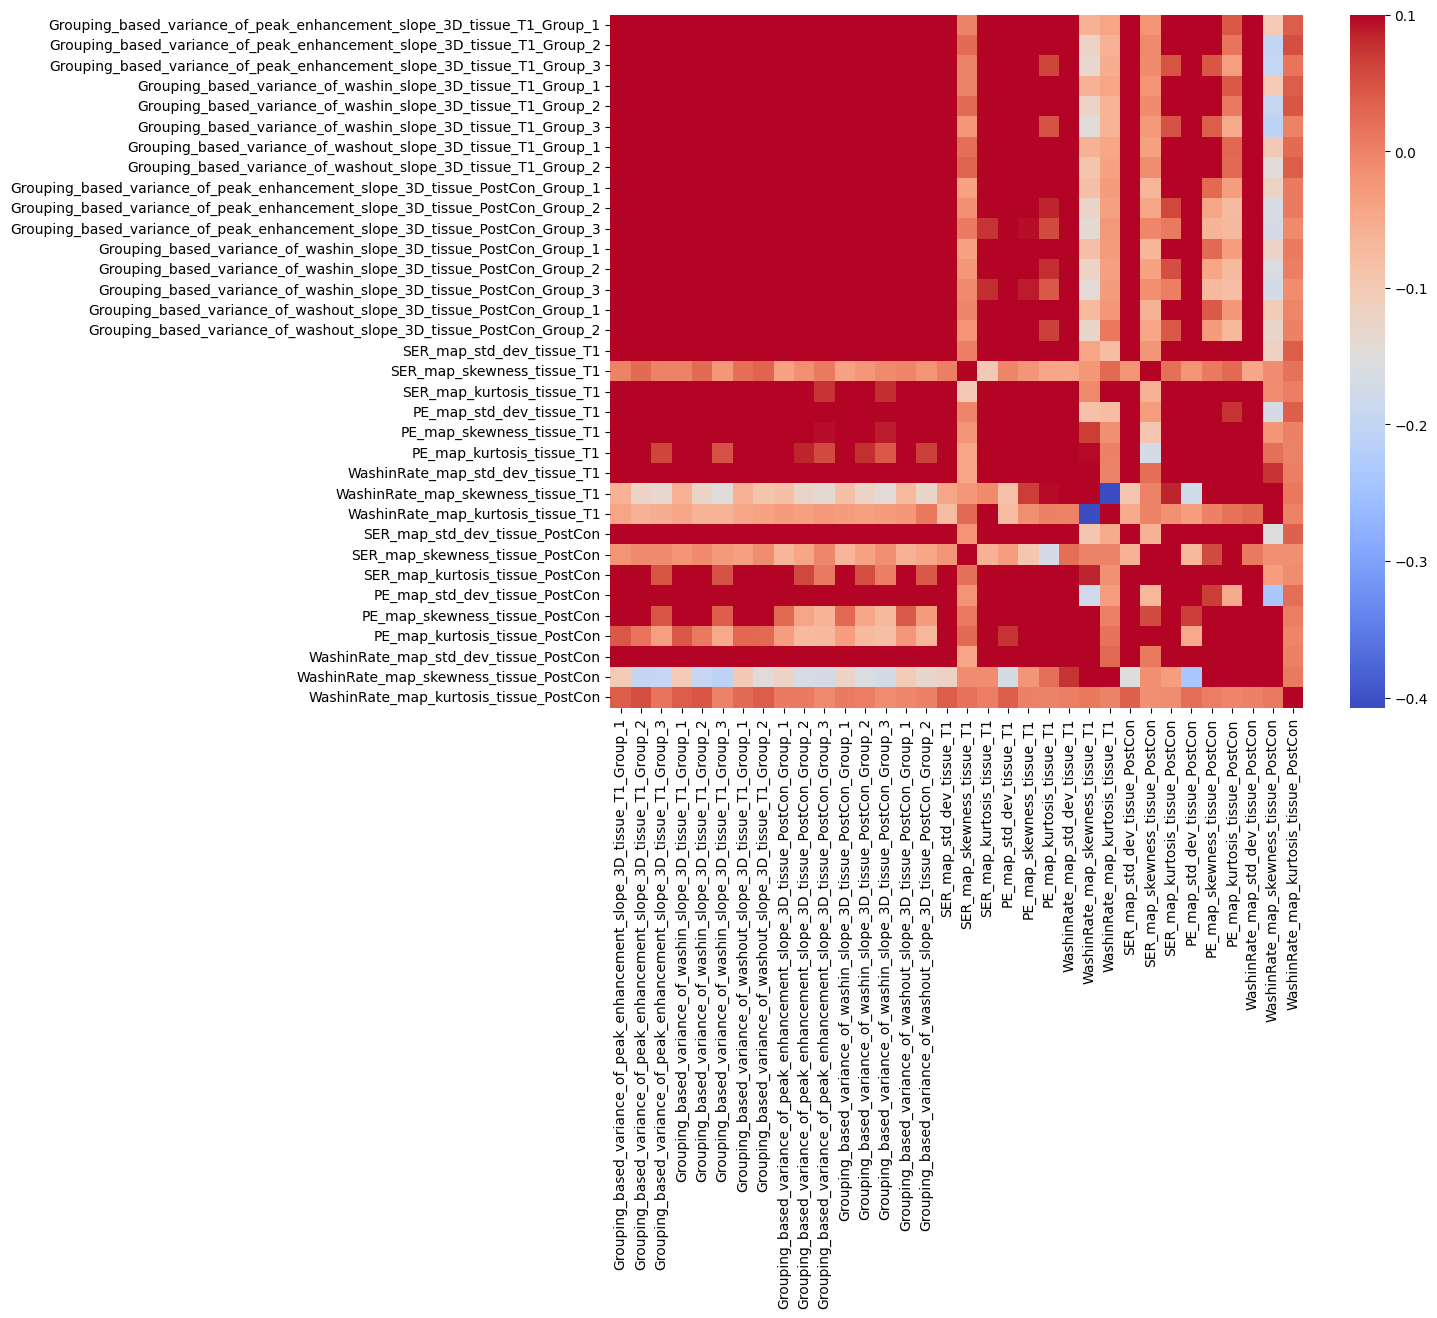

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_FGT_Enhancement_Variation = FGT_Enhancement_Variation.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_FGT_Enhancement_Variation, vmax=.1, square=True,cmap='coolwarm')

###**10-Variacion del realce del tumor.**

In [ ]:
#Filtro solo caracteristicas asociadas a la variacion del relace del tumor. Son solo 35 caracteristicas mas la etiqueta
Tumor_Enhancement_Variation = X[["Maximum_variance_of_enhancement_Tumor","Peak_location_of_enhancement_variance_dynamics_Tumor","Enhancement_variance_increasing_rate_Tumor","Enhancement_variance_decreasing_rate_Tumor","Grouping_based_variance_of_peak_enhancement_slope_3D_tumor_Group_1","Grouping_based_variance_of_peak_enhancement_slope_3D_tumor_Group_2","Grouping_based_variance_of_peak_enhancement_slope_3D_tumor_Group_3","Grouping_based_variance_of_washin_slope_3D_tumor_Group_1","Grouping_based_variance_of_washin_slope_3D_tumor_Group_2","Grouping_based_variance_of_washin_slope_3D_tumor_Group_3","Grouping_based_variance_of_washout_slope_3D_tumor_Group_1","Grouping_based_variance_of_washout_slope_3D_tumor_Group_2","Grouping_based_variance_of_peak_enhancement_slope_2D_tumorSlice_Group_1","Grouping_based_variance_of_peak_enhancement_slope_2D_tumorSlice_Group_2","Grouping_based_variance_of_peak_enhancement_slope_2D_tumorSlice_Group_3","Grouping_based_variance_of_washin_slope_2D_tumorSlice_Group_1","Grouping_based_variance_of_washin_slope_2D_tumorSlice_Group_2","Grouping_based_variance_of_washin_slope_2D_tumorSlice_Group_3","Grouping_based_variance_of_washout_slope_2D_tumorSlice_Group_1","Grouping_based_variance_of_washout_slope_2D_tumorSlice_Group_2","Variance_of_Uptake_Tumor","Change_in_variance_of_Uptake_Tumor","SER_map_std_dev_tumor","SER_map_skewness_tumor","SER_map_kurtosis_tumor","PE_map_std_dev_tumor","PE_map_skewness_tumor","PE_map_kurtosis_tumor","WashinRate_map_std_dev_tumor","WashinRate_map_skewness_tumor","WashinRate_map_kurtosis_tumor","Max_Enhancement_from_char_curv","Time_to_Peak_from_char_curv","Uptake_rate_from_char_curv","Washout_rate_from_char_curv"]]

In [ ]:
#Crea SWEETVIZ_REPORT
my_report = sv.analyze(Tumor_Enhancement_Variation)
my_report.show_html("/content/drive/MyDrive/TESIS/Exploración de datos/SWEETVIZ_REPORT/Tumor_Enhancement_Variation.html")

<Axes: >

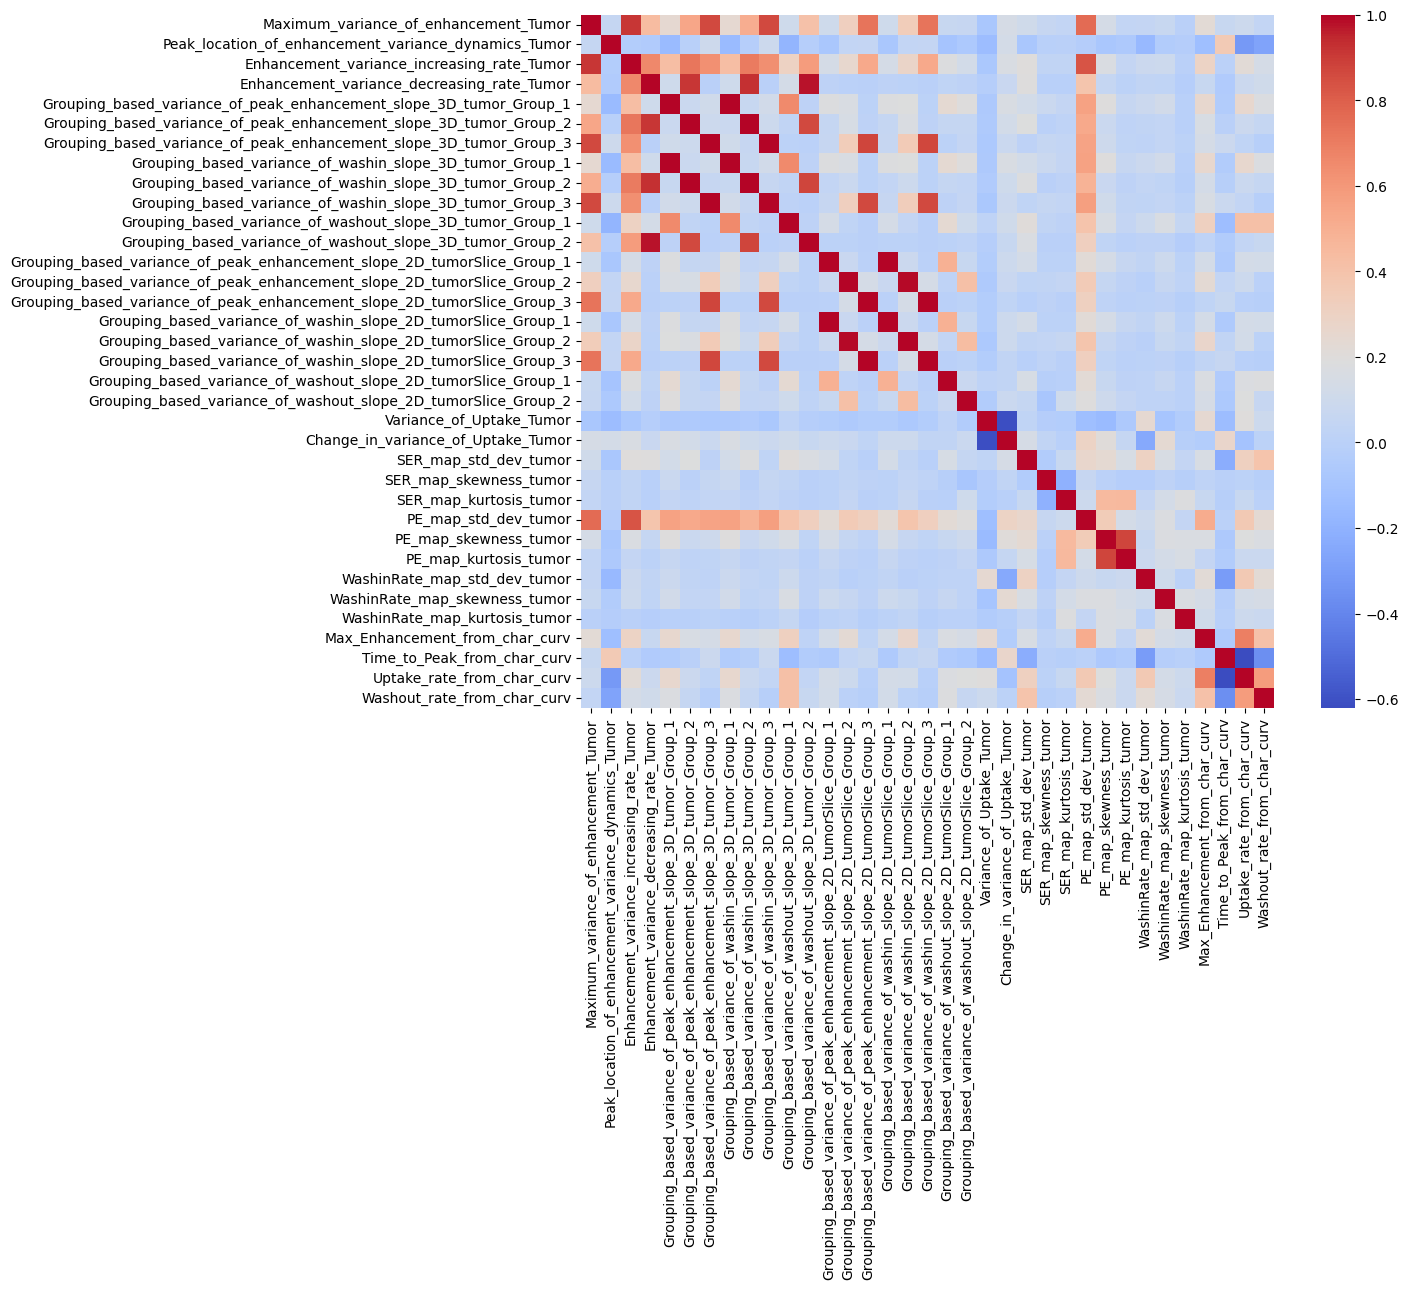

In [ ]:
#plot de correlation matrix 
matriz_Correlacion_Tumor_Enhancement_Variation = Tumor_Enhancement_Variation.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(matriz_Correlacion_Tumor_Enhancement_Variation, vmax=1, square=True, cmap='coolwarm')